<span style="color:purple;font-weight:300;font-size:30px"> 
Food.com - Analysis of user interactions, recipes and reviews
</span>

___________

# Table of Contents
* Graph Network: Creation and analysis
* Communities analysis
* NLP analysis of reviews


In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import os
import sys
sys.path.append(os.path.abspath("../Notebooks"))
from helper_functions import  *
from tqdm import tqdm

#from fa2 import ForceAtlas2
import matplotlib.pyplot as plt
from itertools import count,combinations

from statistics import mean
from scipy import stats

import networkx as nx

%pip install python-louvain
import community.community_louvain as community

import pickle
import matplotlib.cm as cm
from wordcloud import WordCloud
from collections import Counter
from nltk.probability import FreqDist
import math


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import sys
#sys.path.append(os.path.abspath("/Users/lucialarraona/Desktop/finalproject_socialgraphs22/Notebooks"))

from helper_functions import  *

import nltk 
from nltk.stem import PorterStemmer # para ver la raiz de las palabras(worker = work)
from nltk.tokenize import sent_tokenize, word_tokenize # para tokenizar las frases y las palabras 
import re # regex
import string

nltk.download('omw-1.4') #needed for lemmatizing

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer # an nltk package for sentiment analysis :D

import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
from statistics import mean
import seaborn as sns

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lucialarraona/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lucialarraona/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Graph Network
- Create edges and plot graph
- Preliminary analysis
- Community detection and wordclouds
___________________

## Import Data

In [3]:
# Read compressed csv with built-in gzip support
df_recipes = decompress_pickle('../Data/file4.pbz2') 
df_ingredients = pd.read_csv('../Data/ingredients_with_recipies.csv')
df_reviews = decompress_pickle('../Data/reviews_zipped.pbz2') 

In [6]:
# Recipes
print(df_recipes.shape)
df_recipes.head()

(178265, 6)


,name,id,minutes,ingredients,n_ingredients,ingredient_ids
0,arriba baked winter squash mexican style,137739,55,"[winter squash, mexican seasoning, mixed spice...",7,"[7933, 4694, 4795, 3723, 840, 5006, 6270]"
1,a bit different breakfast pizza,31490,30,"[prepared pizza crust, sausage patty, eggs, mi...",6,"[5481, 6324, 2499, 4717, 6276, 1170]"
2,alouette potatoes,59389,45,"[spreadable cheese with garlic and herbs, new ...",11,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627..."
3,apple a day milk shake,5289,0,"[milk, vanilla ice cream, frozen apple juice c...",4,"[4717, 7474, 2946, 150]"
4,aww marinated olives,25274,15,"[fennel seeds, green olives, ripe olives, garl...",9,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131..."


In [7]:
# Ingredients
print(df_ingredients.shape)
df_ingredients.head()

(11659, 9)


,Unnamed: 0,raw_ingr,raw_words,processed,len_proc,replaced,count,id,recipes
0,0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."
1,1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."
2,2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."
3,3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."
4,4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308,"[108804, 34930, 500166, 318677, 140855, 39893,..."


In [56]:
# Reviews
df_reviews.head()
print(df_reviews.shape)

(1132367, 5)


In [8]:
# Convert to dtype datetime and check 
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews.dtypes

user_id               int64
recipe_id             int64
date         datetime64[ns]
rating                int64
review               object
dtype: object

In [9]:
# Filter years 2017 + 2018 as our final subset 
df_reviews_filter = df_reviews[df_reviews['date'].dt.strftime('%Y') > '2016']
df_reviews_filter.shape

(47709, 5)

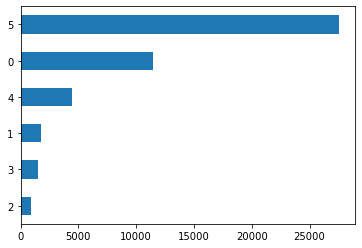

In [10]:
# Value counts for each of the rating values in the subset
df_reviews_filter.rating.value_counts().sort_values().plot(kind = 'barh')
None

## Create edges

In [11]:
recipes_user_dict={id: [] for id in df_recipes['id'].unique()}
print(len(recipes_user_dict))
recipe_error = []

for idx, row in tqdm(df_reviews_filter.iterrows()): 
    try:
        #for ingredient in row['ingredient_ids']:
        recipes_user_dict[row['recipe_id']].append(row['user_id'])
    except:
        recipe_error.append(row['recipe_id'])

# All possible pairs in List using combinations()
edges_ru = [(x,y, {"recipe_id": key})  for key in recipes_user_dict for x, y in list(combinations(recipes_user_dict[key], 2))]   

178265


47709it [00:02, 21165.43it/s]


In [12]:
banana_bread_users= df_reviews_filter[df_reviews_filter['user_id'].isin(df_reviews_filter[df_reviews_filter['recipe_id']==2886]['user_id'])]['user_id']

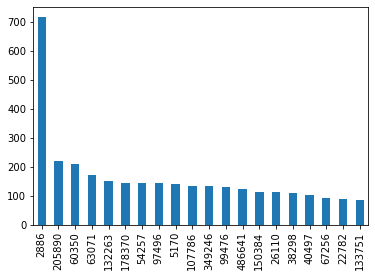

In [14]:
df_reviews_filter['recipe_id'].value_counts().head(20).plot.bar()
None

## Create Graph

In [15]:
G = nx.MultiDiGraph()
G.add_nodes_from(np.unique(df_reviews_filter['user_id'].values))
print(G)

G.add_edges_from(edges_ru)
print(G)

MultiDiGraph with 38250 nodes and 0 edges
MultiDiGraph with 38250 nodes and 590460 edges


In [16]:
df_graph=pd.DataFrame()
df_graph['user_id']=(np.unique(df_reviews_filter['user_id'].values))

# Graph analysis

___________

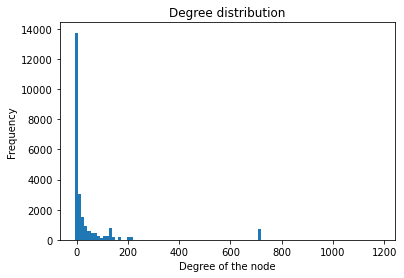

Slope of distribution: -0.9477423223385318


In [17]:
# In and out degree distributions & slope estimate(W5)
def plot_deg_dist(G, title = str):

    degree_list = [val for (node, val) in G.degree() if val != 0]

    counts, edges = np.histogram(degree_list, bins = 100)
    plt.bar(edges[:-1], counts, width=np.diff(edges))
    plt.title(title)
    plt.xlabel('Degree of the node')
    plt.ylabel('Frequency')
    plt.show()
    idx = np.isfinite(np.log(edges[:10])) & np.isfinite(np.log(counts[:10]))
    slope, intercept = np.polyfit(np.log(edges[:10])[idx], np.log(counts[:10])[idx], 1)
    print(f'Slope of distribution: {slope}')

plot_deg_dist(G, title = 'Degree distribution')  
    

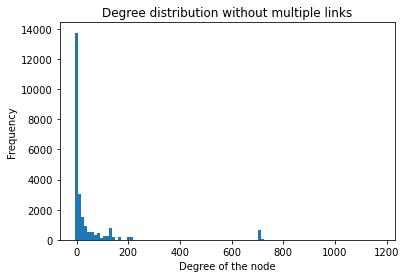

Slope of distribution: -0.9447117454222933


In [19]:
G2 = nx.Graph(G)
plot_deg_dist(G2, title = 'Degree distribution without multiple links')  

In [20]:
# Obtain largest connected component
largest_cc = max(nx.connected_components(G2))
GCC = G2.subgraph(largest_cc).copy()

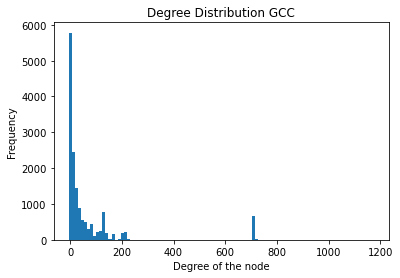

Slope of distribution: -0.7595052310486371


In [21]:
plot_deg_dist(GCC, title = 'Degree Distribution GCC')

In [22]:
degree_list = [val for (node, val) in GCC.degree()]

# Calculate stats
mean = np.mean(degree_list)
median = np.median(degree_list)
mode = stats.mode(degree_list)[0]
d_min = np.min(degree_list)
d_max = np.max(degree_list)

print(f"Mean: {mean}")
print(f'Median:{median}')
print(f'Mode:{mode}')
print(f'Min:{d_min}')
print(f'Max:{d_max}')

Mean: 74.61309562823622
Median:21.0
Mode:[715]
Min:1
Max:1179


In [23]:
# Dataframe with reviews for recipies that are a part of the graph

GCC_multi=G.subgraph(GCC.nodes)

nodes_gcc = [node for node in GCC.nodes]
recipies = [recipe['recipe_id'] for node1, node2, recipe in GCC_multi.edges(data=True)]

df_graph_reviews = df_reviews_filter[df_reviews_filter['user_id'].isin(nodes_gcc) & df_reviews_filter['recipe_id'].isin(recipies)]

In [24]:
#Statistics on number of reviews per user

mean = np.mean(df_graph_reviews['user_id'].value_counts())
median = np.median(df_graph_reviews['user_id'].value_counts())
mode = stats.mode(df_graph_reviews['user_id'].value_counts())[0]
d_min = np.min(df_graph_reviews['user_id'].value_counts())
d_max = np.max(df_graph_reviews['user_id'].value_counts())

print(f"Mean: {mean}")
print(f'Median:{median}')
print(f'Mode:{mode}')
print(f'Min:{d_min}')
print(f'Max:{d_max}')

Mean: 1.256275807825916
Median:1.0
Mode:[1]
Min:1
Max:87


In [72]:
#Statistics on number of reviews per recipe

mean = np.mean(df_graph_reviews['recipe_id'].value_counts())
median = np.median(df_graph_reviews['recipe_id'].value_counts())
mode = stats.mode(df_graph_reviews['recipe_id'].value_counts())[0]
d_min = np.min(df_graph_reviews['recipe_id'].value_counts())
d_max = np.max(df_graph_reviews['recipe_id'].value_counts())

print(f"Mean: {mean}")
print(f'Median:{median}')
print(f'Mode:{mode}')
print(f'Min:{d_min}')
print(f'Max:{d_max}')

Mean: 7.552009456264775
Median:3.0
Mode:[2]
Min:2
Max:716


## Plot Graph with Force Atlas

In [26]:
def plot_graph_fa(G,iterations, edge_color, node_color, title):

    forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)



    # Gets positions of the nodes 
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=iterations)

    # Node size dictionary according to degrees
    d = dict(nx.degree(G))

    # Create color mapping dictionary
    #mapping = {"Marvel": 'red', "DC": 'black'}
    #colors = [mapping[GCC_U.nodes[n]['universe']] for n in GCC_U.nodes()]



    # Plot the Network 
    plt.figure(3,figsize=(25,25)) 
    nc = nx.draw_networkx_nodes(G, 
                        positions, 
                        node_size=[v * 0.1 for v in d.values()], 
                        #node_size = 10,
                        label=True,  
                        node_color=node_color,
                        #cmap=plt.cm.plasma_r, 
                        )

    ec = nx.draw_networkx_edges(G, 
                                positions, 
                                edge_color="#ECC836", 
                                alpha=0.2)

    plt.axis('off')
    plt.title(title, size = 20)
    plt.show()

    

    return None

100%|██████████| 2000/2000 [08:11<00:00,  4.07it/s]


BarnesHut Approximation  took  228.85  seconds
Repulsion forces  took  196.00  seconds
Gravitational forces  took  0.23  seconds
Attraction forces  took  52.39  seconds
AdjustSpeedAndApplyForces step  took  6.50  seconds


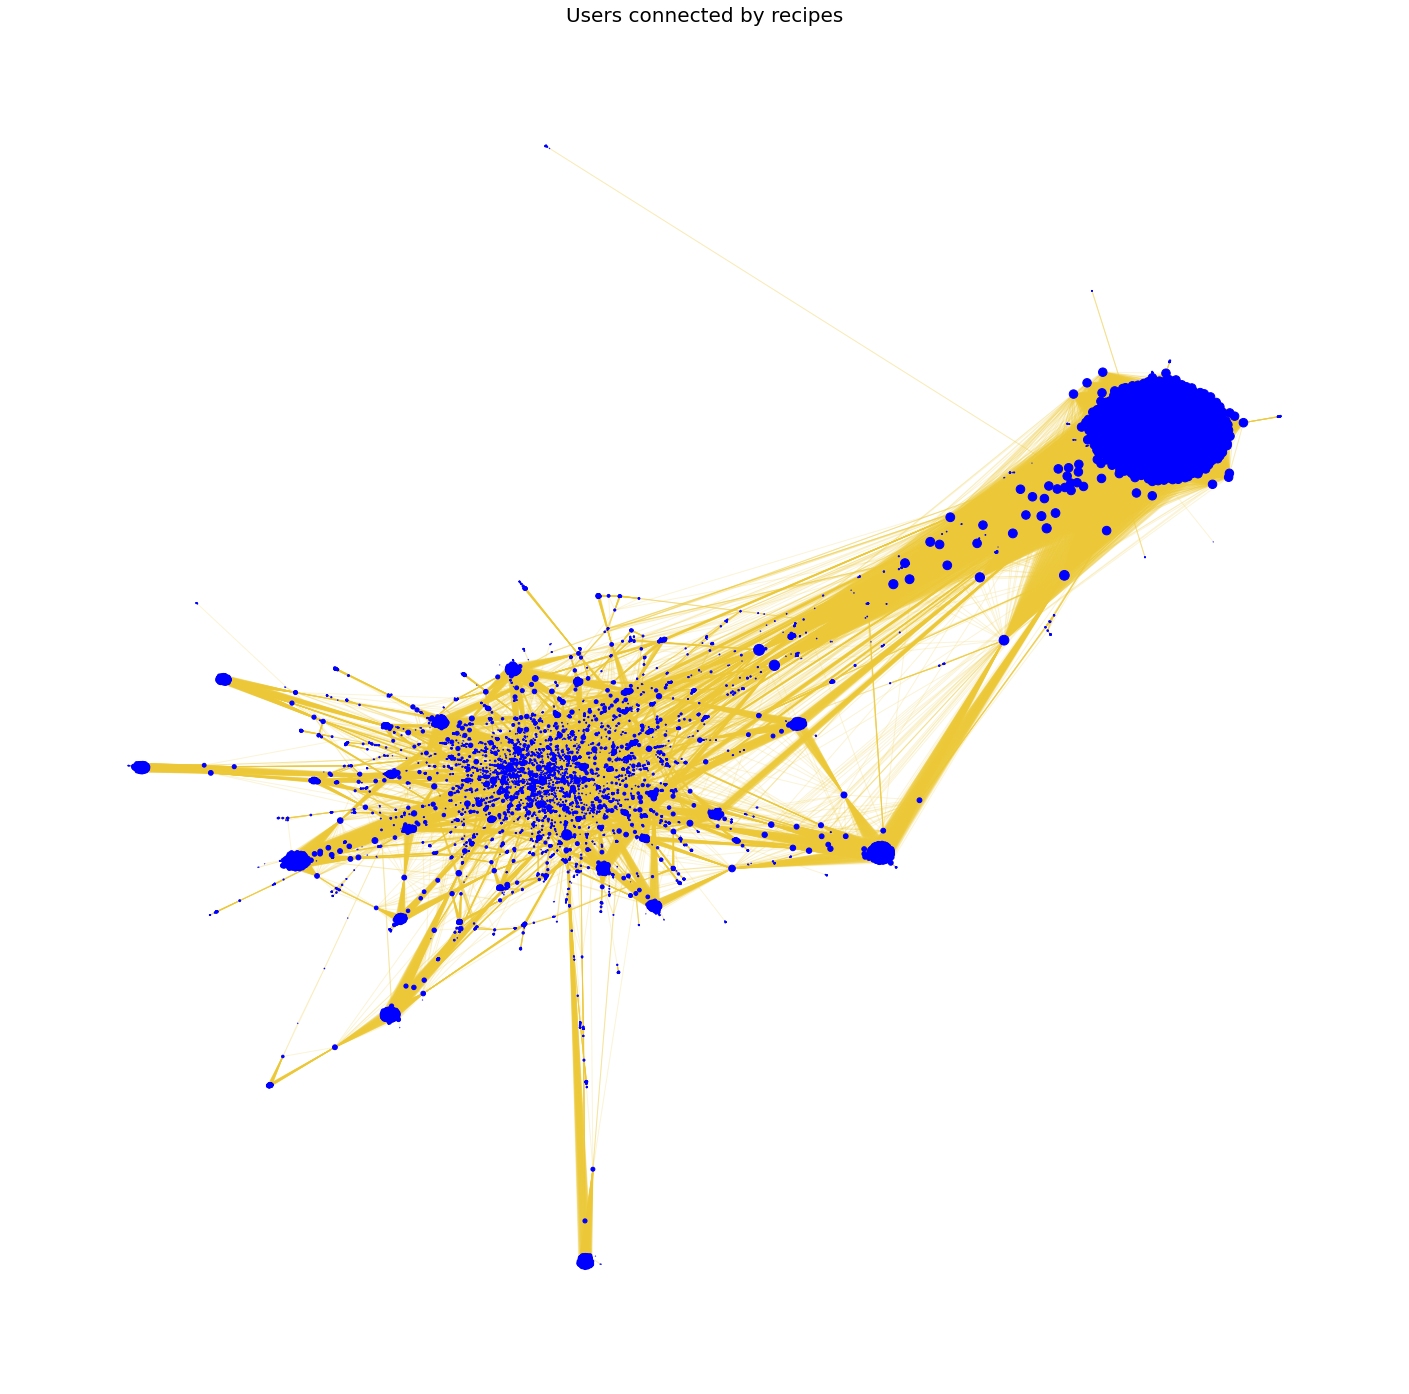

In [29]:
plot_graph_fa(GCC, iterations = 2000, edge_color="#ECC836",node_color='blue', title = 'Users connected by recipes')

# Communities detection

_____________________

In [25]:
'''
Creating partitions

# first compute the best partition for GCC
partition = community.best_partition(GCC)

# find modularity
M = community.modularity(partition, GCC)
print(f"Users graph modularity = {M} - found using community.modularity function")

from collections import Counter

#communities stats
count = Counter(partition.values())
print(f"Number of communities: {len(count)}")

from collections import Counter
count_size = Counter(count.values())

for key in count_size:
    print(f"{count_size[key]} communities of size {key} nodes was found")

largest_10_communities=sorted(count.items(), key=lambda item: item[1])[-10:]

#save partition
def dict_save(dict_partition):
    with open('../Data/partition' + '.pickle', 'wb') as f:
        pickle.dump(dict_partition, f, pickle.HIGHEST_PROTOCOL)

dict_save(partition)

'''
#load previously found partition

def dict_partition_load():
    with open('../Data/partition' + '.pickle', 'rb') as f:
        return pickle.load(f)

partition=dict_partition_load()



## Visualize graph with communities

100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s] 


BarnesHut Approximation  took  178.38  seconds
Repulsion forces  took  171.74  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  39.45  seconds
AdjustSpeedAndApplyForces step  took  3.96  seconds


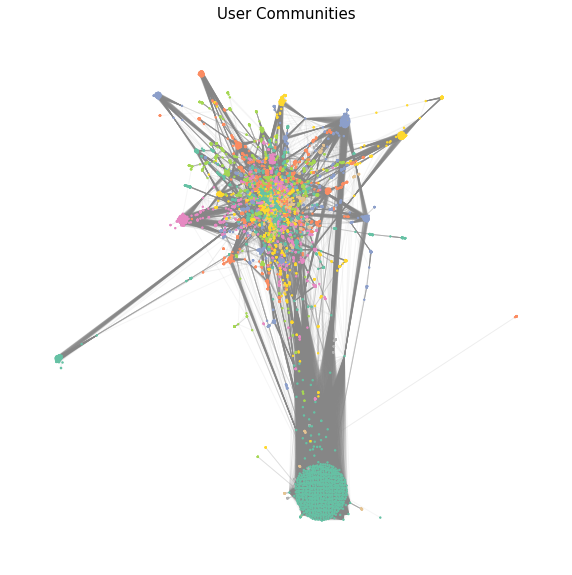

In [34]:
# Visualize with Force Atlas
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=7.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.6,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=15.0,

                        # Log
                        verbose=True)

# Gets positions of the nodes 
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=1000)

plt.figure(3,figsize=(10,10)) 

# color the nodes according to their partition
cmap = cm.get_cmap('Set2', max(partition.values()) + 1)

nc = nx.draw_networkx_nodes(GCC, 
                       positions, 
                       node_size=2.0, 
                       label=True,  
                       node_color=list(partition.values()),
                       cmap=cmap, 
                       )

ec = nx.draw_networkx_edges(GCC, 
                            positions, 
                            edge_color='gray', 
                            alpha=0.07)

plt.axis('off')
plt.title('User Communities', size = 15)
plt.show()

In [26]:
df_graph['community'] = df_graph['user_id'].map(partition)
df_graph= df_graph.dropna()

df_graph.shape

# Save the df with the community numbers 
df_graph.to_csv('user_community_map.csv', index=False)

In [27]:
 # Take the largest 10 
largest_com = dict(df_graph['community'].value_counts().head(10))
list_largest_com = list(largest_com.keys())
print(f'The 10 largest communities are: {list_largest_com}')

The 10 largest communities are: [12.0, 0.0, 5.0, 37.0, 52.0, 2.0, 11.0, 14.0, 10.0, 27.0]


In [28]:
#Make a subgraph for community

nodes_c1=df_graph[df_graph['community']==list_largest_com [0]]['user_id']

G_C1=G.subgraph(nodes_c1)
print(G_C1)

#find 
recipies = [recipe['recipe_id'] for node1, node2, recipe in G_C1.edges(data=True)]

c1_recipies=np.unique(np.array(recipies))
len(c1_recipies)

#IN PROGRESS - Ingredients workcloudszx

df_recipes['ingredients_str'] = df_recipes['ingredients'].apply(lambda x: ' '.join(x))
ing=''.join(''.join(df_recipes[df_recipes['id'].isin(c1_recipies)].ingredients_str.values))

MultiDiGraph with 859 nodes and 9471 edges


In [29]:
df_recipes['ingredients_str'] = df_recipes['ingredients'].apply(lambda x: ' '.join(x))


def community_subgraph(community_idx):

    #make a subgraph for community
    nodes_c1=df_graph[df_graph['community']==community_idx]['user_id']
    G_C1=G.subgraph(nodes_c1)
    #print(G_C1)

    return G_C1



## Plotting each community graph alone

In [ ]:
# Plotting the communities graphs

#////// TODO  plot all of them, for some reason sometimes the kernel blocks - Lu


com_graphs = {}

for community_idx in list_largest_com:
    GC_subgraph = community_subgraph(community_idx)
    com_graphs[community_idx] = GC_subgraph


# list(com_graphs.values())[0]

#plot_graph_fa(list(com_graphs.values())[0], iterations = 1000, edge_color="#ECC836",node_color='blue', title = 'Users Community 1')

## Community wordclouds

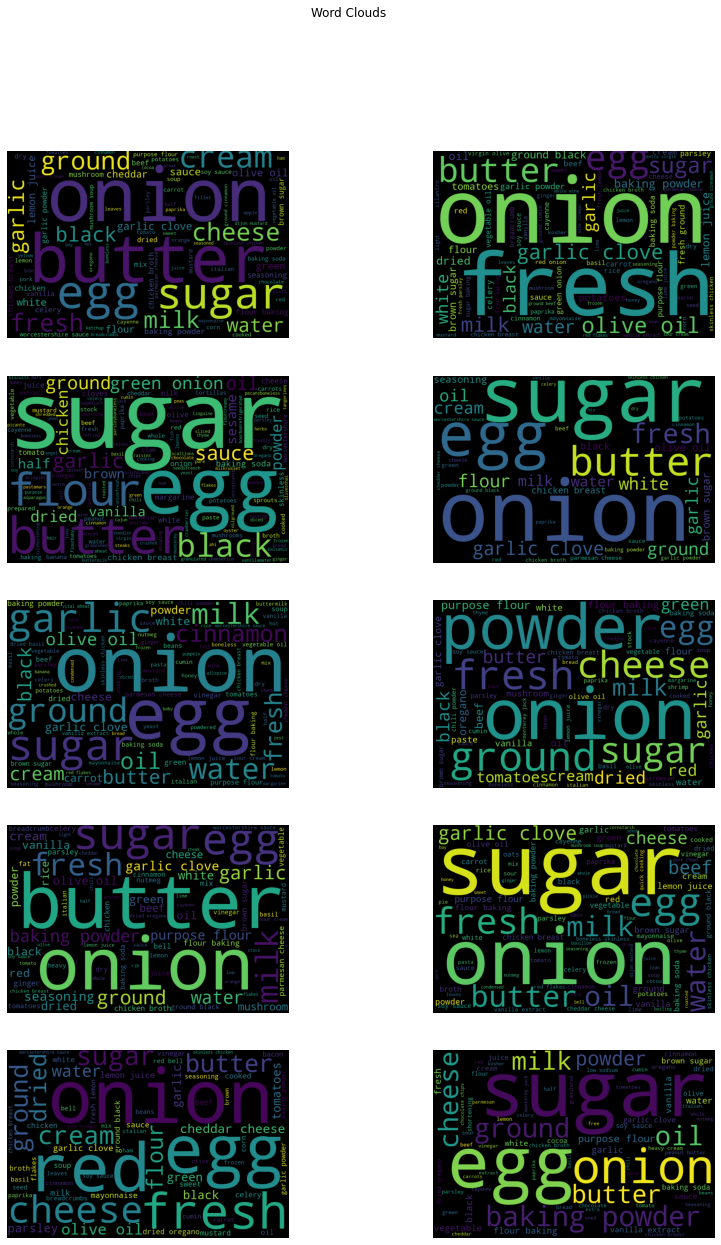

In [30]:
def ingredients_list(G_C1):
    #return ingredients list for recipies that are part of the graph

    #find 
    recipies = [recipe['recipe_id'] for node1, node2, recipe in G_C1.edges(data=True)]

    c_recipies=np.unique(np.array(recipies))
    #IN PROGRESS - Ingredients workclouds
    ing=''.join(''.join(df_recipes[df_recipes['id'].isin(c_recipies)].ingredients_str.values))
    return ing


fig = plt.figure(figsize=(14, 20))
fig.patch.set_alpha(0.0)    
fig.suptitle('Word Clouds')

k=0

for community_idx in list_largest_com:

    GC_subgraph = community_subgraph(community_idx)
    ingredients = ingredients_list(GC_subgraph)
    ing_list = ingredients.split(" ")
    

    #print(f'Top 10 ingredients for community {community_idx}:')

    counter =Counter(ing_list)
    top_10=counter.most_common(10)
    
    #print(top_10)

    #remove onion, salt, pepper - most common ing in every community
    ingredients = ingredients.replace('salt', "").replace('pepper', "")

    
    word_cloud = WordCloud(width=900,
                           height=600,
                           #background_color='white',
                           min_font_size=14).generate(ingredients)

    plt.subplot(5, 2, k + 1)
    plt.imshow(word_cloud)
    plt.axis('off')
    
    k+=1
    

In [31]:

# Calculate TF and extract 5 most common words for each of the 10 communities in the marvel universe
def TF_com(dic_texts, printing=False):
     # List to store all TF for every community in the dictionary of texts
    TF_com_global = []
    for key, value in dic_texts.items():
        #TF for 1 community
        TF_com = FreqDist(value)
        TF_com_global.append(TF_com)
         #Most common 5 words for 1 community
        most_common_marvel_com = TF_com.most_common(5)
        print(f'Community {key}')
        print(most_common_marvel_com)
    return TF_com_global

TF_com_global = []

for community_idx in list_largest_com:

    GC_subgraph = community_subgraph(community_idx)
    ingredients = ingredients_list(GC_subgraph)
    ingredients = ingredients.replace('salt ', "").replace('pepper ', "")

    ing_list = ingredients.split(" ")


    #print(f'Top 10 ingredients for community {community_idx}:')

    counter =Counter(ing_list )
    top_10=counter.most_common(10)

    TF_com = FreqDist(ing_list)
    TF_com_global.append(TF_com)

    #Most common 5 words for 1 community
    most_common_marvel_com = TF_com.most_common(10)
    print(f'Community {community_idx}')
    print(most_common_marvel_com)
    print(top_10)




Community 12.0
[('garlic', 48), ('onion', 46), ('sugar', 42), ('butter', 40), ('chicken', 40), ('cheese', 38), ('sauce', 36), ('powder', 36), ('flour', 36), ('cream', 35)]
[('garlic', 48), ('onion', 46), ('sugar', 42), ('butter', 40), ('chicken', 40), ('cheese', 38), ('sauce', 36), ('powder', 36), ('flour', 36), ('cream', 35)]
Community 0.0
[('fresh', 159), ('garlic', 150), ('oil', 148), ('ground', 137), ('sugar', 132), ('onion', 132), ('powder', 103), ('butter', 97), ('olive', 85), ('black', 85)]
[('fresh', 159), ('garlic', 150), ('oil', 148), ('ground', 137), ('sugar', 132), ('onion', 132), ('powder', 103), ('butter', 97), ('olive', 85), ('black', 85)]
Community 5.0
[('sugar', 11), ('butter', 10), ('chicken', 9), ('flour', 8), ('green', 7), ('black', 7), ('garlic', 7), ('sauce', 7), ('eggs', 6), ('baking', 6)]
[('sugar', 11), ('butter', 10), ('chicken', 9), ('flour', 8), ('green', 7), ('black', 7), ('garlic', 7), ('sauce', 7), ('eggs', 6), ('baking', 6)]
Community 37.0
[('garlic', 66

In [32]:
# Calculate IDF for each of the communities 
def IDF_com(TF_com_global,N):
    IDF_global = []
    for i in range(N):
        IDF = []
        for term, term_freq in TF_com_global[i].items():
            term_IDF = math.log(float(N) / term_freq + 1)
            IDF.append((term,term_IDF))
        IDF_global.append(IDF)

    return IDF_global

IDF_global = IDF_com(TF_com_global,N=10)

# Sort TF words to match the order of the IDF lists
TF_com_global_sorted = []
N=10
for i in range(N):
        TF_com_sorted = [] 
        for term, term_freq in TF_com_global[i].items():
                elem = (term,term_freq)
                #list of sorted words and freq of 1 comunnity
                TF_com_sorted.append(elem)
        # append it to the list of lists
        TF_com_global_sorted.append(TF_com_sorted)

# Calculate TF-IDF for each of the communities

def TF_IDF_com(TF_com_global_sorted,IDF_global):
    
    TF_IDF_global = []

    for i in range(N):
        # convert to dict to multiply easy
        dict_1 = dict(TF_com_global_sorted[i])
        dict_2 = dict(IDF_global[i])
        result = {key: dict_1[key] * dict_2[key] for key in dict_1}
        
        #Append it to the list of communities
        TF_IDF_global.append(result) 
    return TF_IDF_global

# finally returns list
TF_IDF_global = TF_IDF_com(TF_com_global_sorted,IDF_global)

In [33]:
#TF_IDF_global[0].values.sort()
dict(sorted(TF_IDF_global[1].items(), key=lambda item: item[1], reverse=True)) #Checking highest scores for TFIDF

{'fresh': 9.698127519751868,
 'garlic': 9.680778170635675,
 'oil': 9.676648370902054,
 'ground': 9.651877550233747,
 'sugar': 9.639317821965456,
 'onion': 9.639317821965456,
 'powder': 9.543859539718591,
 'butter': 9.517432027976772,
 'olive': 9.454178984369074,
 'black': 9.454178984369074,
 'red': 9.44198748460261,
 'juice': 9.401907653669292,
 'lemon': 9.38723572155045,
 'milk': 9.371825165319104,
 'sauce': 9.371825165319104,
 'cheese': 9.363825233870239,
 'flour': 9.363825233870239,
 'baking': 9.338553003013585,
 'cream': 9.237574580800855,
 'water': 9.225752288521873,
 'dried': 9.225752288521873,
 'green': 9.225752288521873,
 'chicken': 9.225752288521873,
 'white': 9.200970872311474,
 'cloves': 9.200970872311474,
 'egg': 9.187974656474143,
 'and': 9.10014014395955,
 'vinegar': 9.066472307851107,
 'eggs': 9.066472307851107,
 'tomatoes': 9.030181295796806,
 'parsley': 8.990947307918054,
 'brown': 8.79600498983171,
 'potatoes': 8.79600498983171,
 'beef': 8.79600498983171,
 'onions': 8

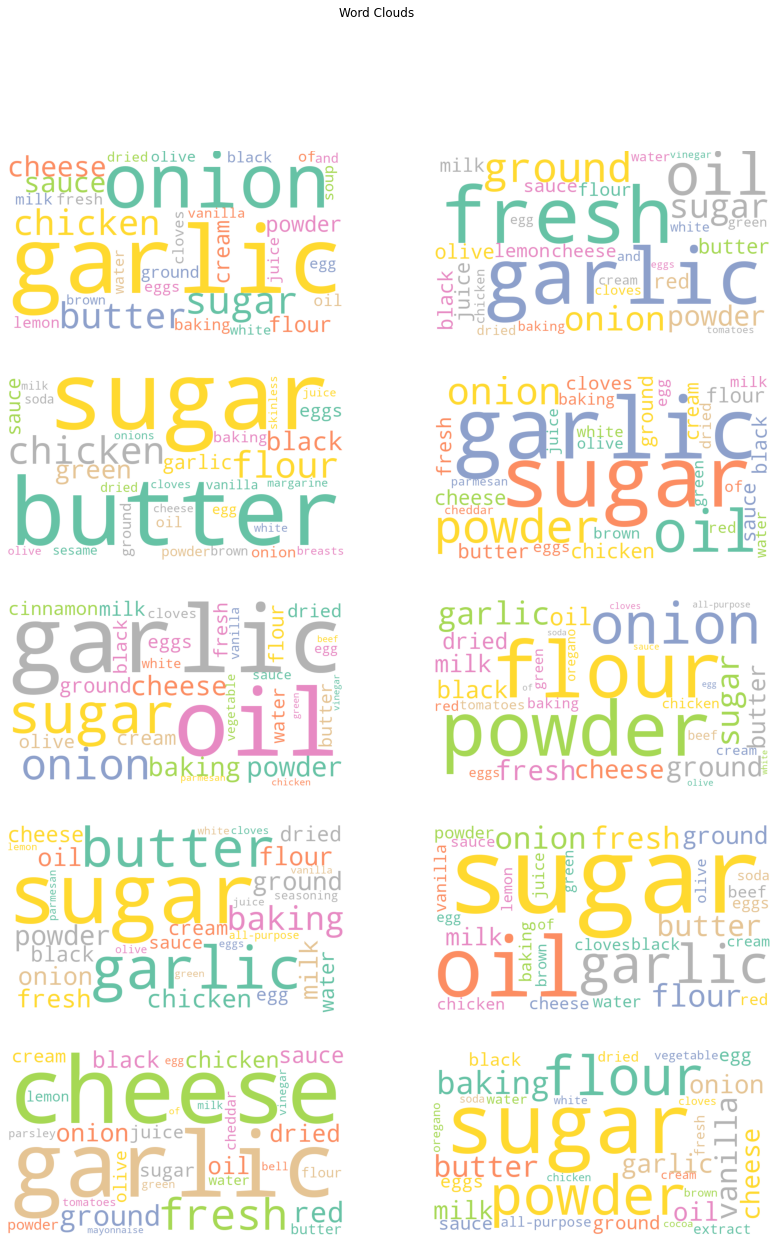

In [34]:
fig = plt.figure(figsize=(14, 20))
fig.patch.set_alpha(0.0)    
fig.suptitle('Word Clouds')

k=0

for i in range(len(list_largest_com)):


    word_cloud = WordCloud(width=900,height=500, 
                            max_words=30,
                            background_color='white',
                            colormap= 'Set2',
                            collocations= False,
                            relative_scaling=1,
                            normalize_plurals=False).fit_words(TF_IDF_global[i])

    plt.subplot(5, 2, k + 1)
    plt.tick_params(which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        labelbottom=False,
                        left= False,
                        labelleft = False) # labels along the bottom edge are off
    plt.imshow(word_cloud)
    plt.axis('off')
    
    k+=1

In [35]:
def create_inv_community_graph(community_idx):
    GC_subgraph = community_subgraph(community_idx)
    community_users = GC_subgraph.nodes
    recipies_community = [recipe['recipe_id'] for node1, node2, recipe in GC_subgraph.edges(data=True)]


    user_recipies_dict={id: [] for id in community_users}

    df_reviews_filter_community = df_reviews_filter[(df_reviews_filter['user_id'].isin(community_users)) & (df_reviews_filter['recipe_id'].isin(recipies_community))]



    for idx, row in tqdm(df_reviews_filter_community.iterrows()): 
        try:
            #for ingredient in row['ingredient_ids']:
            user_recipies_dict[row['user_id']].append(row['recipe_id'])
        except:
            recipe_error.append(row['user_id'])
#print(user_recipies_dict)

    edges_community = [(x,y, {"user_id": key})  for key in user_recipies_dict for x, y in list(combinations(user_recipies_dict[key], 2))] 
    G_inverse = nx.MultiDiGraph()
    G_inverse.add_nodes_from(recipies_community)
    G_inverse.add_edges_from(edges_community)

    return G_inverse

In [36]:
for community_idx in list_largest_com:
    graph = create_inv_community_graph(community_idx)
    d_c=nx.degree_centrality(graph)
    sorted_centrality= sorted(d_c.items(), key=lambda x: x[1], reverse=True)
    most_common_recipe_id = sorted_centrality[0][0]
    recipe_highest_centrality = df_recipes.loc[df_recipes['id'] == most_common_recipe_id]
    print(f'The recipe with highest centrality is - {recipe_highest_centrality.iloc[0][0]}')
    

1005it [00:00, 23947.44it/s]


The recipe with highest centrality is - simple baked chicken drumsticks


1548it [00:00, 25112.29it/s]


The recipe with highest centrality is - jumbo shrimp parmesan


764it [00:00, 18503.25it/s]


The recipe with highest centrality is - best banana bread


887it [00:00, 22971.49it/s]


The recipe with highest centrality is - creamy turkey tetrazzini


655it [00:00, 23747.43it/s]


The recipe with highest centrality is - copycat olive garden minestrone soup by todd wilbur


609it [00:00, 25094.62it/s]


The recipe with highest centrality is - creamy cajun chicken pasta


616it [00:00, 23387.32it/s]


The recipe with highest centrality is - easy moist banana blueberry muffins


564it [00:00, 24845.74it/s]


The recipe with highest centrality is - best ever tuna noodle casserole


560it [00:00, 24947.53it/s]

The recipe with highest centrality is - olive garden copycat zuppa toscana

534it [00:00, 24982.53it/s]

The recipe with highest centrality is - better than olive garden alfredo sauce


# NLP Analysis of Reviews' text

___________________________________

In [2]:
# With the reviews dataset, map the community for each user 
df_reviews = decompress_pickle('../Data/reviews_zipped.pbz2') 
print(df_reviews.shape)
df_reviews.head()

(1132367, 5)


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [3]:
df_recipes = decompress_pickle('../Data/file4.pbz2') 
df_ingredients = pd.read_csv('../Data/ingredients_with_recipies.csv')

In [38]:
df_recipes = df_recipes.rename(columns={'id':'recipe_id'})
df_recipes.head()

,name,recipe_id,minutes,ingredients,n_ingredients,ingredient_ids,ingredients_str
0,arriba baked winter squash mexican style,137739,55,"[winter squash, mexican seasoning, mixed spice...",7,"[7933, 4694, 4795, 3723, 840, 5006, 6270]",winter squash mexican seasoning mixed spice ho...
1,a bit different breakfast pizza,31490,30,"[prepared pizza crust, sausage patty, eggs, mi...",6,"[5481, 6324, 2499, 4717, 6276, 1170]",prepared pizza crust sausage patty eggs milk s...
2,alouette potatoes,59389,45,"[spreadable cheese with garlic and herbs, new ...",11,"[1170, 4918, 6426, 5185, 7099, 5006, 6009, 627...",spreadable cheese with garlic and herbs new po...
3,apple a day milk shake,5289,0,"[milk, vanilla ice cream, frozen apple juice c...",4,"[4717, 7474, 2946, 150]",milk vanilla ice cream frozen apple juice conc...
4,aww marinated olives,25274,15,"[fennel seeds, green olives, ripe olives, garl...",9,"[2587, 3437, 5002, 3184, 5324, 5068, 5058, 131...",fennel seeds green olives ripe olives garlic p...


5    816364
4    187360
0     60847
3     40855
2     14123
1     12818
Name: rating, dtype: int64


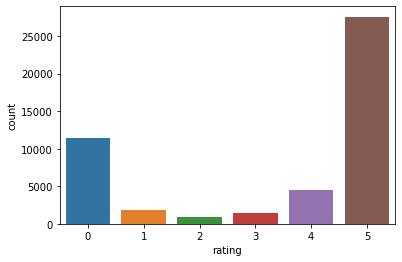

In [37]:
sns.countplot(x='rating', data=df_reviews_filter)
None
print(df_reviews['rating'].value_counts())

In [39]:
df_com_map = pd.read_csv('user_community_map.csv')
print(df_com_map.shape)
df_com_map.head()

(15257, 2)


,user_id,community
0,1535,11.0
1,3288,2.0
2,4439,0.0
3,4470,0.0
4,4769,36.0


In [42]:
df_reviews_raw = pd.merge(df_com_map, df_reviews_filter, how="left", on=["user_id"]) # merging left is using only the keys on the left df, in this case df_com_map
print(df_reviews_raw.shape)
df_reviews_raw.head()

(23370, 6)


,user_id,community,recipe_id,date,rating,review
0,1535,11.0,432196,2017-06-30,4,I used fresh herbs and skipped the sugar. Surp...
1,1535,11.0,155375,2017-03-29,5,"When I ran across this recipe, I thought it so..."
2,1535,11.0,477446,2017-03-14,5,Using quality Irish whiskey really improves th...
3,1535,11.0,29253,2017-06-20,5,AMAZING! This was my first time making ciabatt...
4,1535,11.0,153642,2017-07-18,5,"These moist muffins have an excellent flavor, ..."


In [44]:
df_reviews_raw = pd.merge(df_reviews_raw, df_recipes, how='left',on =['recipe_id'])
df_reviews_raw = df_reviews_raw.dropna()
df_reviews_raw.head()

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,ingredients_str
0,1535,11.0,432196,2017-06-30,4,I used fresh herbs and skipped the sugar. Surp...,grilled balsamic eggplant,25.0,"[eggplant, fresh basil, olive oil, balsamic vi...",10.0,"[2516, 2757, 5006, 339, 2320, 2324, 3203, 6906...",eggplant fresh basil olive oil balsamic vinega...
1,1535,11.0,155375,2017-03-29,5,"When I ran across this recipe, I thought it so...",chicken broccoli alfredo soup,30.0,"[onion, garlic cloves, butter, flour, low sodi...",14.0,"[5010, 3203, 840, 2683, 1257, 3590, 5180, 7655...",onion garlic cloves butter flour low sodium ch...
2,1535,11.0,477446,2017-03-14,5,Using quality Irish whiskey really improves th...,traditional irish coffee,5.0,"[irish whiskey, sugar, hot coffee, whipped cream]",4.0,"[3921, 6906, 3778, 7702]",irish whiskey sugar hot coffee whipped cream
3,1535,11.0,29253,2017-06-20,5,AMAZING! This was my first time making ciabatt...,ciabatta bread,150.0,"[water, salt, white sugar, olive oil, bread fl...",6.0,"[7655, 6270, 7790, 5006, 721, 7956]",water salt white sugar olive oil bread flour b...
4,1535,11.0,153642,2017-07-18,5,"These moist muffins have an excellent flavor, ...",easy moist banana blueberry muffins,30.0,"[bananas, sugar, egg, butter, blueberries, bak...",9.0,"[342, 6906, 2499, 840, 648, 335, 332, 6270, 2683]",bananas sugar egg butter blueberries baking so...


In [45]:
# Make a copy to keep the raw dataframe for the future 
df_reviews2 = df_reviews_raw.reset_index(drop=True)

## Cleaning text 

In [46]:
def text_cleaning(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

stopwords = nltk.corpus.stopwords.words('english')

ps = PorterStemmer()
wn = nltk.WordNetLemmatizer()

def clean_stem (review):

    temp1 ="".join(x for x in review if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3


def clean_lemma (review):
    
    temp1 ="".join(x for x in review if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [wn.lemmatize(x) for x in temp2 if x not in stopwords]
    return temp3


df_reviews2['review'] =df_reviews2['review'] .astype('str')  # object to string
df_reviews2['review'] = df_reviews2['review'] .apply(text_cleaning) # cleaning 
df_reviews2['review_tokens']= df_reviews2['review'].map(clean_lemma) # apply lemmatization for now
df_reviews2.head(2)

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,ingredients_str,review_tokens
0,1535,11.0,432196,2017-06-30,4,i used fresh herbs and skipped the sugar surp...,grilled balsamic eggplant,25.0,"[eggplant, fresh basil, olive oil, balsamic vi...",10.0,"[2516, 2757, 5006, 339, 2320, 2324, 3203, 6906...",eggplant fresh basil olive oil balsamic vinega...,"[used, fresh, herb, skipped, sugar, surprising..."
1,1535,11.0,155375,2017-03-29,5,when i ran across this recipe i thought it so...,chicken broccoli alfredo soup,30.0,"[onion, garlic cloves, butter, flour, low sodi...",14.0,"[5010, 3203, 840, 2683, 1257, 3590, 5180, 7655...",onion garlic cloves butter flour low sodium ch...,"[ran, across, recipe, thought, sounded, like, ..."


In [47]:
#//// Sanity check of differneces between lemmatizing and stemming
print(df_reviews2['review'][1])
print(clean_lemma(df_reviews2['review'][1]))
print()
print(df_reviews2['review'][1])
print(clean_stem(df_reviews2['review'][1]))

when i ran across this recipe  i thought it sounded like something my family would love  being on a  quot lower fat quot  diet  there was no way i could make it as written though  i was really pleased with how well the recipe modified to meet my dietary needs  it was still rich and delicious  and everyone loved it  here is my lightened up version  http   www food com recipe light chicken broccoli alfredo soup lower fat  served with http   www food com recipe italian herb parmesan bread bread machine abm 
['ran', 'across', 'recipe', 'thought', 'sounded', 'like', 'something', 'family', 'would', 'love', 'quot', 'lower', 'fat', 'quot', 'diet', 'way', 'could', 'make', 'written', 'though', 'really', 'pleased', 'well', 'recipe', 'modified', 'meet', 'dietary', 'need', 'still', 'rich', 'delicious', 'everyone', 'loved', 'lightened', 'version', 'http', 'www', 'food', 'com', 'recipe', 'light', 'chicken', 'broccoli', 'alfredo', 'soup', 'lower', 'fat', 'served', 'http', 'www', 'food', 'com', 'recipe

## Calculate Sentiment of text

In [48]:
sid = SentimentIntensityAnalyzer()


# Sentiment compound value of reviews
def sentiment(x):
    score = sid.polarity_scores(x)
    return score['compound']


#  Add Positive y Negative tag 
def cls(x):
    list1=[]
    for i in x["score"]:
        if i>0:
            list1.append("Positive")
        elif i==0:
            list1.append("Neutral")
        else:
            list1.append("Negative")
    x["sentiment"]=list1



df_reviews2['score']= df_reviews2['review'].apply(lambda x : sentiment(x)) #score
cls(df_reviews2) # tag (for plotting)
df_reviews2.head(2) 

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,ingredients_str,review_tokens,score,sentiment
0,1535,11.0,432196,2017-06-30,4,i used fresh herbs and skipped the sugar surp...,grilled balsamic eggplant,25.0,"[eggplant, fresh basil, olive oil, balsamic vi...",10.0,"[2516, 2757, 5006, 339, 2320, 2324, 3203, 6906...",eggplant fresh basil olive oil balsamic vinega...,"[used, fresh, herb, skipped, sugar, surprising...",0.2551,Positive
1,1535,11.0,155375,2017-03-29,5,when i ran across this recipe i thought it so...,chicken broccoli alfredo soup,30.0,"[onion, garlic cloves, butter, flour, low sodi...",14.0,"[5010, 3203, 840, 2683, 1257, 3590, 5180, 7655...",onion garlic cloves butter flour low sodium ch...,"[ran, across, recipe, thought, sounded, like, ...",0.9558,Positive
2,1535,11.0,477446,2017-03-14,5,using quality irish whiskey really improves th...,traditional irish coffee,5.0,"[irish whiskey, sugar, hot coffee, whipped cream]",4.0,"[3921, 6906, 3778, 7702]",irish whiskey sugar hot coffee whipped cream,"[using, quality, irish, whiskey, really, impro...",0.5262,Positive
3,1535,11.0,29253,2017-06-20,5,amazing this was my first time making ciabatt...,ciabatta bread,150.0,"[water, salt, white sugar, olive oil, bread fl...",6.0,"[7655, 6270, 7790, 5006, 721, 7956]",water salt white sugar olive oil bread flour b...,"[amazing, first, time, making, ciabatta, last,...",0.7717,Positive
4,1535,11.0,153642,2017-07-18,5,these moist muffins have an excellent flavor ...,easy moist banana blueberry muffins,30.0,"[bananas, sugar, egg, butter, blueberries, bak...",9.0,"[342, 6906, 2499, 840, 648, 335, 332, 6270, 2683]",bananas sugar egg butter blueberries baking so...,"[moist, muffin, excellent, flavor, especially,...",0.7089,Positive


In [49]:
import plotly as ply
import plotly.graph_objs as go

Mno=df_reviews2[df_reviews2.sentiment=="Positive"]["score"].count()
Fno=df_reviews2[df_reviews2.sentiment=="Negative"]["score"].count()
Nno=df_reviews2[df_reviews2.sentiment=="Neutral"]["score"].count()
labels = ["Positive Comments","Negative Comments","Neutral Comments"]
values = [Mno,Fno,Nno]
fig = go.Figure(data=[go.Pie(labels=labels, values=values,hole=0.4)])
fig.show()

## Reescaling the sentiment as a new rating score (1-5)

In [50]:
# Rescaling the score to 0-1 and then divinding by 5 to match the range of the rating and comapre

from sklearn.preprocessing import minmax_scale

df_reviews2[['score_scale']] = minmax_scale(df_reviews2[['score']])
df_reviews2[['score_scale2']] = df_reviews2[['score_scale']]*5
df_reviews2.head(2)

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,ingredients_str,review_tokens,score,sentiment,score_scale,score_scale2
0,1535,11.0,432196,2017-06-30,4,i used fresh herbs and skipped the sugar surp...,grilled balsamic eggplant,25.0,"[eggplant, fresh basil, olive oil, balsamic vi...",10.0,"[2516, 2757, 5006, 339, 2320, 2324, 3203, 6906...",eggplant fresh basil olive oil balsamic vinega...,"[used, fresh, herb, skipped, sugar, surprising...",0.2551,Positive,0.624078,3.120390
1,1535,11.0,155375,2017-03-29,5,when i ran across this recipe i thought it so...,chicken broccoli alfredo soup,30.0,"[onion, garlic cloves, butter, flour, low sodi...",14.0,"[5010, 3203, 840, 2683, 1257, 3590, 5180, 7655...",onion garlic cloves butter flour low sodium ch...,"[ran, across, recipe, thought, sounded, like, ...",0.9558,Positive,0.978074,4.890371


### Plot distribution of true rating

The mean of the sentiment in the reviews: 3.691471877282688
90th percentile of the sentiment:  5.0
10th percentile of the sentiment:  0.0


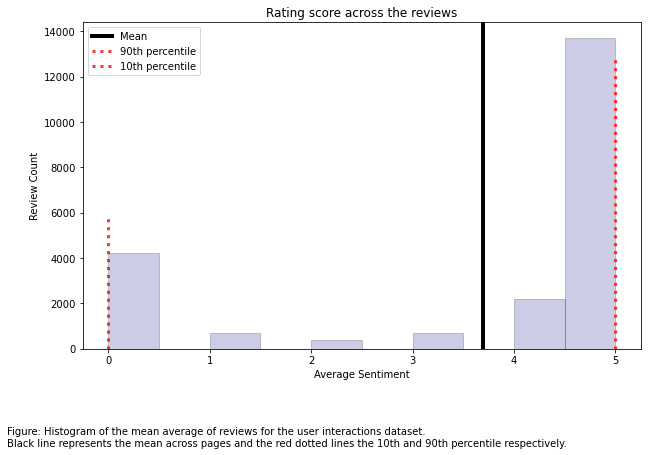

In [51]:
# Mean, 10th and 90th percentile of the sentiment

mean_rev= df_reviews2['rating'].describe()['mean']

print(f'The mean of the sentiment in the reviews: {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(df_reviews2['rating'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(df_reviews2['rating'], 10))


# Add the percentiles to a list for the plotting
percentiles = [np.percentile(df_reviews2['rating'], 90), np.percentile(df_reviews2['rating'], 10)]


# Plotting 
list_sentiment = list(zip(df_reviews2['user_id'], df_reviews2['rating']))

def plot_pretty_hist(list_data, percentiles, mean, plot_perct = False, title = str, color=str):

    x = [val for (node, val) in list_data]
    fig,ax = plt.subplots(figsize = (10,6))
    cnts, values, bars = ax.hist(x, edgecolor='black', 
                                        bins=10,
                                        color=color,
                                        alpha = 0.2)

    if plot_perct == True:
        # Plot mean
        ax.axvline(mean, color='black', linestyle = '-', linewidth=4) 
        # Plot percentiles and mean lines
        quants = [[percentiles[0], 0.8, 0.90], [percentiles[1], 0.8, 0.40]]
        for i in quants:
            ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'Red' ,linewidth=3)  

        
        # Labels and titles
        ax.set_ylabel("Review Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean','90th percentile','10th percentile'])
        caption = ("Figure: Histogram of the mean average of reviews for the user interactions dataset.\n"
                    "Black line represents the mean across pages and the red dotted lines the 10th and 90th percentile respectively.")
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()
        
        

    else:
        
        # Plot the mean
        ax.axvline(mean, color='black', linewidth=4) 
        
        # Labels and titles
        ax.set_ylabel("Page Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean'])
        caption = ('haha')
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()

    return None

plot_pretty_hist(list_sentiment,percentiles, mean_rev, plot_perct= True, 
                 title="Rating score across the reviews",
                 color = 'darkblue')

### Plot distribution of the new calculated rating

The mean of the sentiment in the reviews: 4.060603272324288
90th percentile of the sentiment:  4.890800242497726
10th percentile of the sentiment:  2.476002829140143


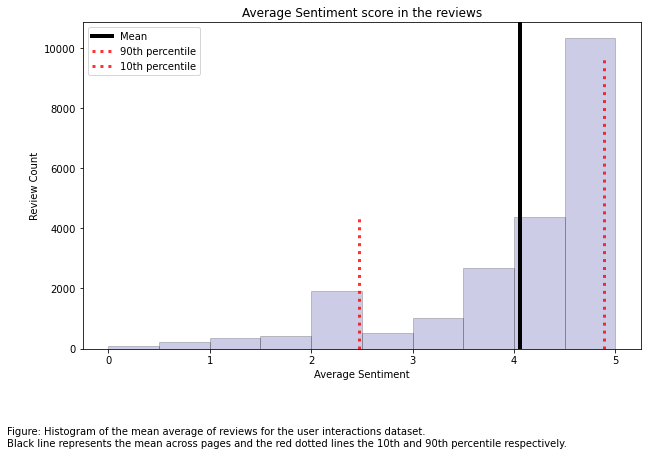

In [52]:
# Mean, 10th and 90th percentile of the sentiment

mean_rev= df_reviews2['score_scale2'].describe()['mean']

print(f'The mean of the sentiment in the reviews: {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(df_reviews2['score_scale2'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(df_reviews2['score_scale2'], 10))


# Add the percentiles to a list for the plotting
percentiles = [np.percentile(df_reviews2['score_scale2'], 90), np.percentile(df_reviews2['score_scale2'], 10)]

list_sentiment = list(zip(df_reviews2['user_id'], df_reviews2['score_scale2']))

def plot_pretty_hist(list_data, percentiles, mean, plot_perct = False, title = str, color=str):

    x = [val for (node, val) in list_data]
    fig,ax = plt.subplots(figsize = (10,6))
    cnts, values, bars = ax.hist(x, edgecolor='black', 
                                        bins=10,
                                        color=color,
                                        alpha = 0.2)

    if plot_perct == True:
        # Plot mean
        ax.axvline(mean, color='black', linestyle = '-', linewidth=4) 
        # Plot percentiles and mean lines
        quants = [[percentiles[0], 0.8, 0.90], [percentiles[1], 0.8, 0.40]]
        for i in quants:
            ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'Red' ,linewidth=3)  

        
        # Labels and titles
        ax.set_ylabel("Review Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean','90th percentile','10th percentile'])
        caption = ("Figure: Histogram of the mean average of reviews for the user interactions dataset.\n"
                    "Black line represents the mean across pages and the red dotted lines the 10th and 90th percentile respectively.")
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()
        
        

    else:
        
        # Plot the mean
        ax.axvline(mean, color='black', linewidth=4) 
        
        # Labels and titles
        ax.set_ylabel("Page Count")
        ax.set_xlabel("Average Sentiment")
        ax.set_title(f"{title}")
        ax.legend(['Mean'])
        caption = ('haha')
        fig.text(0.02,-0.1, caption, ha='left')
        
        # Remove ticks and spines
        for ax, spine in ax.spines.items():
            spine.set_visible(True)
        plt.show()

    return None


plot_pretty_hist(list_sentiment,percentiles, mean_rev, plot_perct= True, 
                title="Average Sentiment score in the reviews",
                color = 'darkblue')

### Label Permutation Test

> **Label permutation test to investigate the two hypotheses below**
>* **H1: Good reviews (>4 rating) have a higher averge value for sentiment than a similarly sized set of randomly rated reviews.**
>* **H2: Bad reviews (<4) have a lower average value for sentiment than a similarly sized set of randomly rated reviews.**
>* **Write a short paragraph reflecting on your findings.**

In [53]:
# We will relabel de dataset for easier permutation test analysis:
threshold = 3.5
df_reviews2['good'] = df_reviews2['score_scale2'].map(lambda x: 1 if x > threshold else 0)
df_reviews2['bad'] = df_reviews2['score_scale2'].map(lambda x: 1 if x < threshold else 0 )
df_reviews2.head(2)

,user_id,community,recipe_id,date,rating,review,name,minutes,ingredients,n_ingredients,ingredient_ids,ingredients_str,review_tokens,score,sentiment,score_scale,score_scale2,good,bad
0,1535,11.0,432196,2017-06-30,4,i used fresh herbs and skipped the sugar surp...,grilled balsamic eggplant,25.0,"[eggplant, fresh basil, olive oil, balsamic vi...",10.0,"[2516, 2757, 5006, 339, 2320, 2324, 3203, 6906...",eggplant fresh basil olive oil balsamic vinega...,"[used, fresh, herb, skipped, sugar, surprising...",0.2551,Positive,0.624078,3.120390,0,1
1,1535,11.0,155375,2017-03-29,5,when i ran across this recipe i thought it so...,chicken broccoli alfredo soup,30.0,"[onion, garlic cloves, butter, flour, low sodi...",14.0,"[5010, 3203, 840, 2683, 1257, 3590, 5180, 7655...",onion garlic cloves butter flour low sodium ch...,"[ran, across, recipe, thought, sounded, like, ...",0.9558,Positive,0.978074,4.890371,1,0


In [56]:
# Shuffle the good/bad attribute

avg_score_shuffle_good = []
avg_score_shuffle_bad = []
avg_score_good = []
avg_score_bad = []


for _ in range(1000):
    
    # Create a list of shuffled good attribute and append it to the df_reviews2
    df_reviews2['good_shuffled'] = np.random.permutation(df_reviews2['good'])
    df_reviews2['bad_shuffled'] = np.random.permutation(df_reviews2['bad'])
    
    # Create a new df for every iteration on the loop 
    df_test = pd.DataFrame() 
    df_test['user_id'] = df_reviews2['user_id']       #character
    df_test['good_true'] = df_reviews2['good']              #true labels
    df_test['bad_true'] = df_reviews2['bad'] # true labels
    df_test['good_shuffled'] = df_reviews2['good_shuffled'] #shuffled labels
    df_test['bad_shuffled'] = df_reviews2['bad_shuffled']  #shuffled labels
    df_test['score_scale2'] = df_reviews2['score_scale2']


    # group with just characters and shuffled labels (random group)
    shuffled_group_good = df_test[df_test['good_shuffled']== 1] # good characters
    avg_score_shuffle_good.append(np.mean(shuffled_group_good['score_scale2'])) 
    
    # group with just characters and shuffled labels (random group)
    shuffled_group_bad = df_test[df_test['bad_shuffled']== 1] # bad characters
    avg_score_shuffle_bad.append(np.mean(shuffled_group_bad['score_scale2']))

# group with just characters and their true labels 
true_group_good = df_reviews2[df_reviews2['good'] == 1]
avg_score_good = np.mean(true_group_good['score_scale2']) #it will always be the same number because of the true labels

# group with just characters and their true labels 
true_group_bad = df_reviews2[df_reviews2['bad'] == 1]
avg_score_bad = np.mean(true_group_bad['score_scale2']) #it will always be the same number because of the true labels

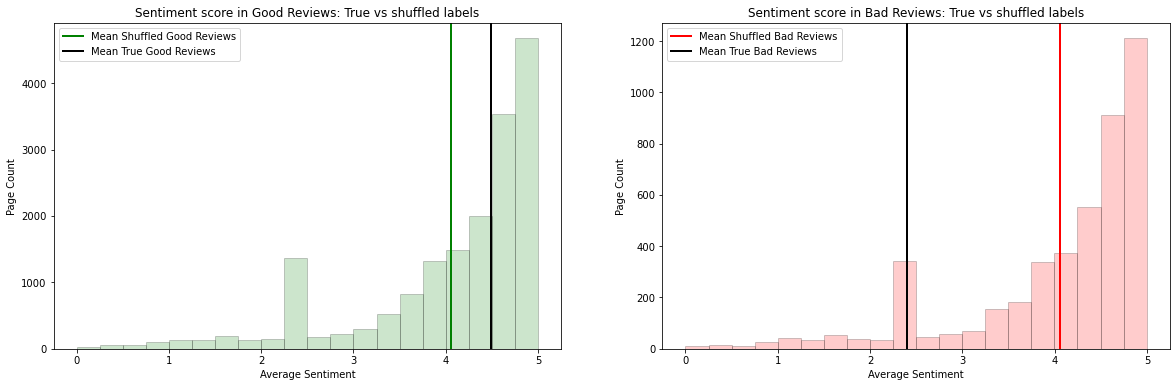

In [65]:
def plot_pretty_hist_pair(shuffled_group_good, true_group_good, shuffled_group_bad, true_group_bad):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))


    # H1
    list_shuffle_good = list(zip(shuffled_group_good['user_id'], shuffled_group_good['score_scale2']))
    x_good = [val for (node, val) in list_shuffle_good]
    
    cnts, values, bars = ax1.hist(x_good, edgecolor='black', 
                                     bins=20,
                                     color='green',
                                     alpha = 0.2)

    # Mean of shuffled labels
    ax1.axvline(np.mean(avg_score_shuffle_good), color='green', linewidth=2)
    # Mean of true labels
    ax1.axvline(avg_score_good, color='black', linewidth=2)

    # Labels and titles
    ax1.set_ylabel("Page Count")
    ax1.set_xlabel("Average Sentiment")
    ax1.set_title("Sentiment score in Good Reviews: True vs shuffled labels")
    ax1.legend(['Mean Shuffled Good Reviews','Mean True Good Reviews'])


    
    
    # ----------------------------
    
    # H2
    list_shuffle = list(zip(shuffled_group_bad['user_id'], shuffled_group_bad['score_scale2']))
    x = [val for (node, val) in list_shuffle]
    cnts, values, bars = ax2.hist(x, edgecolor='black', 
                                     bins=20,
                                     color='red',
                                     alpha = 0.2)
    # Mean of shuffled labels
    ax2.axvline(np.mean(avg_score_shuffle_bad), color='red', linewidth=2) 
    # Mean of true labels
    ax2.axvline(avg_score_bad, color='black', linewidth=2) 
    

    # Labels and titles
    ax2.set_ylabel("Page Count")
    ax2.set_xlabel("Average Sentiment")
    ax2.set_title("Sentiment score in Bad Reviews: True vs shuffled labels")
    ax2.legend(['Mean Shuffled Bad Reviews','Mean True Bad Reviews'])


    plt.show()

    pass

    return None


plot_pretty_hist_pair(shuffled_group_good, true_group_good, shuffled_group_bad, true_group_bad)

# Highest rated ingredients and worst rated ingredients
- 10 most popular ingredients from highest rated reviews
- 10 least popular ingredients from lowest rated reviews

In [76]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

In [77]:
# Take 10 most popular recipes (sort daframe by rating)

#top_rated = df_reviews2.sort_values(by=['rating'], ascending=False).head(10)
top_rated = df_reviews2[df_reviews2['score_scale2'] > 4.5]
list_ing  = list(top_rated["ingredients"])
flat_list_ing = [item for sublist in list_ing for item in sublist]
freq_ing_top_rated = nltk.FreqDist(flat_list_ing).most_common(10)
freq_ing_top_rated

[('salt', 5835),
 ('butter', 3727),
 ('sugar', 2626),
 ('eggs', 2479),
 ('flour', 2407),
 ('onion', 1926),
 ('milk', 1845),
 ('water', 1610),
 ('baking powder', 1551),
 ('baking soda', 1495)]

In [78]:
TF_com = FreqDist(flat_list_ing)

most_common = TF_com.most_common(10)
print(f'Most popular ingredients (among best rated reviews)')
print(most_common)

import math
IDF = []
for term, term_freq in TF_com.items():
    term_IDF = math.log(float(1) / term_freq + 1)
    IDF.append((term,term_IDF))

# convert to dict to multiply easy
dict_1 = dict(TF_com)
dict_2 = dict(IDF)
TF_IDF = {key: dict_1[key] * dict_2[key] for key in dict_1}
TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=True)) # no reverse to check the highest TFIDF scores
print('Most popoular ingredients TFIDF filtered (higher TFIDF score)')
list(TF_IDF.items())[:10]

Most popular ingredients (among best rated reviews)
[('salt', 5835), ('butter', 3727), ('sugar', 2626), ('eggs', 2479), ('flour', 2407), ('onion', 1926), ('milk', 1845), ('water', 1610), ('baking powder', 1551), ('baking soda', 1495)]
Most popoular ingredients TFIDF filtered (higher TFIDF score)


[('salt', 0.9999143199862045),
 ('butter', 0.9998658678348885),
 ('sugar', 0.9998096446684739),
 ('eggs', 0.9997983599925362),
 ('flour', 0.999792330054601),
 ('onion', 0.999740484425146),
 ('milk', 0.9997290951735222),
 ('water', 0.9996895695296165),
 ('baking powder', 0.999677765835823),
 ('baking soda', 0.9996657009053146)]

In [79]:
worst_rated = df_reviews2[df_reviews2['score_scale2'] < 2]
list_ing  = list(worst_rated["ingredients"])
flat_list_ing = [item for sublist in list_ing for item in sublist]
freq_ing_worst_rated = nltk.FreqDist(flat_list_ing).most_common(10)
freq_ing_worst_rated

[('salt', 612),
 ('butter', 384),
 ('sugar', 304),
 ('flour', 278),
 ('eggs', 263),
 ('baking powder', 231),
 ('milk', 208),
 ('water', 201),
 ('onion', 197),
 ('all-purpose flour', 156)]

In [80]:
TF_com = FreqDist(flat_list_ing)

most_common = TF_com.most_common(10)
print(f'Least popular ingredients (among best rated reviews)')
print(most_common)

import math
IDF = []
for term, term_freq in TF_com.items():
    term_IDF = math.log(float(1) / term_freq + 1)
    IDF.append((term,term_IDF))

# Convert to dict to multiply easy
dict_1 = dict(TF_com)
dict_2 = dict(IDF)
TF_IDF = {key: dict_1[key] * dict_2[key] for key in dict_1}
TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=True))
print('Least popoular ingredients TFIDF filtered (higher TFIDF score)')
list(TF_IDF.items())[:10]

Least popular ingredients (among best rated reviews)
[('salt', 612), ('butter', 384), ('sugar', 304), ('flour', 278), ('eggs', 263), ('baking powder', 231), ('milk', 208), ('water', 201), ('onion', 197), ('all-purpose flour', 156)]
Least popoular ingredients TFIDF filtered (higher TFIDF score)


[('salt', 0.9991838954178108),
 ('butter', 0.998700172822057),
 ('sugar', 0.9983588611617656),
 ('flour', 0.9982057403425341),
 ('eggs', 0.9981036647290535),
 ('baking powder', 0.9978417243832837),
 ('milk', 0.9976038308065468),
 ('water', 0.9975206577679485),
 ('onion', 0.997470485439687),
 ('all-purpose flour', 0.9968085034082742)]

# Community analysis of Actual Rating vs Calculated Score
* a) Rating vs Sentiment score by community
* b) Rating vs Sentiment score by recipe in each community
    - How many recipes in each community have the same score?
* c) Rating vs Sentiment score by user in each community
    - How many recipes have each user rated?

### a) **Average Rating vs Sentiment score by community**

In [81]:
df_mean_rating= pd.DataFrame(df_reviews2.groupby(by=["community"])['rating','score_scale2'].mean())
df_mean_rating

,rating,score_scale2
community,,
0.0,4.141102,4.296715
1.0,2.400000,3.749141
2.0,3.681440,4.031366
3.0,2.625000,4.317091
4.0,4.000000,3.597605
...,...,...
64.0,4.500000,3.847504
65.0,4.400000,4.024283
66.0,2.142857,3.227782


In [82]:
df_mean_rating = df_mean_rating.reset_index()

In [83]:
df_mean_rating[df_mean_rating['community'].isin(list_largest_com)]

,community,rating,score_scale2
0,0.0,4.141102,4.296715
2,2.0,3.681440,4.031366
5,5.0,3.897025,4.213940
10,10.0,3.198198,3.945124
11,11.0,3.605364,4.031653
12,12.0,3.771257,4.089480
14,14.0,3.531100,4.048511
27,27.0,3.640909,4.127838
37,37.0,3.770492,4.009708
52,52.0,3.542153,3.981361


### b) **Average Rating vs Sentiment score per recipe by community**

In [86]:
df_mean_rating_recipe= pd.DataFrame(df_reviews2.groupby(by=["community",'recipe_id'])['rating','score_scale2'].mean())
df_mean_rating_recipe

rating  score_scale2
community recipe_id                        
0.0       432        5.000000      4.924219
          567        1.666667      3.840263
          916        0.500000      2.628574
          2462       5.000000      4.783773
          5219       4.000000      4.416237
...                       ...           ...
64.0      302743     4.000000      3.043346
65.0      505862     4.400000      4.024283
66.0      115565     2.142857      3.227782
67.0      9327       5.000000      4.407093
68.0      175091     3.750000      3.380507

[6366 rows x 2 columns]

In [87]:
list_largest_com

[12.0, 0.0, 5.0, 37.0, 52.0, 2.0, 11.0, 14.0, 10.0, 27.0]

In [88]:
# THE LARGEST OF THE LARGEST IS COMMUNITY NUMBER = 
# Mean, 10th and 90th percentile of the sentiment in each community

# Select community 0
com0 = df_mean_rating_recipe['rating'].loc[12, :]
com0 = com0.reset_index()

mean_rev= com0['rating'].describe()['mean']

print(f'The mean of the sentiment in the reviews in community : {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(com0['rating'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(com0['rating'], 10))

# Add the percentiles to a list for the plotting
percentiles = [np.percentile(com0['rating'], 90), np.percentile(com0['rating'], 10)]

The mean of the sentiment in the reviews in community : 4.154183053325472
90th percentile of the sentiment:  5.0
10th percentile of the sentiment:  2.4875000000000003


In [90]:
# THE 2nd LARGEST OF THE LARGEST IS COMMUNITY NUMBER = 
# Mean, 10th and 90th percentile of the sentiment in each community

# Select community 0
com0 = df_mean_rating_recipe['rating'].loc[0, :]
com0 = com0.reset_index()

mean_rev= com0['rating'].describe()['mean']

print(f'The mean of the sentiment in the reviews in community : {mean_rev}')
print("90th percentile of the sentiment: ",
       np.percentile(com0['rating'], 90))

print("10th percentile of the sentiment: ",
       np.percentile(com0['rating'], 10))

# Add the percentiles to a list for the plotting
percentiles = [np.percentile(com0['rating'], 90), np.percentile(com0['rating'], 10)]

The mean of the sentiment in the reviews in community : 4.3308780531340965
90th percentile of the sentiment:  5.0
10th percentile of the sentiment:  2.5
